In [2]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
import plotly.express as px

In [19]:
#generate random data and study the correctness of the classifiers and other aspects.
X = np.random.normal(0,1,(1000,4))
X[:,2] = X[:,2]*2
X[:,3] = X[:,3]*1.5
X[:,1] += X[:,2] +X[:,3]
W = np.random.rand(4,1)
z = 1/(1 + np.exp(-( X @ W )))
y = (z >0.5).astype(int).reshape(-1)
X,y = torch.tensor(X),torch.tensor(y)

train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

class MyDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        x, y = self.X[index],self.y[index]
        return x, y
        
    def __len__(self):
        return len(self.X)
    
train_dataset, valid_dataset,test_dataset = torch.utils.data.random_split(MyDataset(X,y), [train_size, val_size, test_size])


In [88]:
from models.NonParametric import ParzenWindow
from Metrics import ComputeMetrics
compute_metrics = ComputeMetrics(2)
metrics_dict = {}
hyperparamter_grid_params = []
for whitten in [False,True]:
    for h in tqdm(np.logspace(-3, 1, 20)):
        X_train,y_train = train_dataset[:]
        pw = ParzenWindow(h=h,whitten=whitten)
        pw.fit(X_train,y_train)
        #valid
        X_val,y_val = valid_dataset[:]
        y_pred = pw.predict(X_val)
        metrics_dict[h] = compute_metrics(y_pred,y_val)

    #choice for hyper parameters
    hyperparamter_grid = []
    for h,metrics in metrics_dict.items():
        hyperparamter_grid.append([h,metrics[1]["f1"]])
    hyperparamter_grid_params.append(np.array(hyperparamter_grid))


100%|██████████| 20/20 [00:00<00:00, 96.21it/s] 


In [89]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Scatter(x=hyperparamter_grid_params[0][:,0], y=hyperparamter_grid_params[0][:,1],name="non - whitened data")],
    layout=go.Layout(
        xaxis_title="h", yaxis_title="f1 score", width=600,height=400,title='f1 score with varying window width (h)'
    )
)
fig.add_trace( go.Scatter(x=hyperparamter_grid_params[1][:,0], y=hyperparamter_grid_params[1][:,1],name = "whitened data"))
fig.show()

In [114]:
for i,whitten in enumerate([False,True]):
   best_hyperparm = hyperparamter_grid_params[i][hyperparamter_grid_params[i][:,1].argmax()][0]
   pw = ParzenWindow(h=best_hyperparm,whitten=whitten)
   pw.fit(X_train,y_train)
   #compute model variance
   metrics_dict = {}
   for i in range(10):
      test_set_size = int(len(test_dataset) * 0.8)
      leftout_size = len(test_dataset) - test_set_size
      train_set, valid_set = torch.utils.data.random_split(test_dataset, [test_set_size, leftout_size])
      y_pred = pw.predict(X_val)
      metrics_dict[i] = compute_metrics(y_pred,y_val)
   #choice for hyper parameters
   epoch_grid = []
   for h,metrics in metrics_dict.items():
      epoch_grid.append(metrics[1]["f1"].item())
   print(np.mean(epoch_grid), np.var(epoch_grid))

0.9699879884719849 0.0
1.0 0.0


In [37]:
import torch
from Metrics import ComputeMetrics
compute_metrics = ComputeMetrics(10)
from sklearn.linear_model import LogisticRegression
import numpy as np
metrics_dict = torch.load("models/pzn_metrics.pt")

In [47]:
hyperparamter_grid = []
for k,metrics in metrics_dict.items():
    hyperparamter_grid.append([k,metrics[1]["f1"]])
hyperparamter_grid = np.array(hyperparamter_grid)
best_hyperparm = hyperparamter_grid[hyperparamter_grid[:,1].argmax()][0]
best_hyperparm

3.79269019073225

In [48]:
hyperparamter_grid

array([[ 0.1       ,  0.2648297 ],
       [ 0.1274275 ,  0.27540883],
       [ 0.16237767,  0.23921385],
       [ 0.20691381,  0.2214326 ],
       [ 0.26366509,  0.24786544],
       [ 0.33598183,  0.22529927],
       [ 0.42813324,  0.20868735],
       [ 0.54555948,  0.2012538 ],
       [ 0.6951928 ,  0.22650215],
       [ 0.88586679,  0.19561514],
       [ 1.12883789,  0.2308743 ],
       [ 1.43844989,  0.26497236],
       [ 1.83298071,  0.3476325 ],
       [ 2.33572147,  0.44567475],
       [ 2.97635144,  0.54805809],
       [ 3.79269019,  0.63867575],
       [ 4.83293024,  0.60322797],
       [ 6.15848211,  0.54871255],
       [ 7.8475997 ,  0.46848935],
       [10.        ,  0.37664491]])

In [49]:


import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Scatter(x=hyperparamter_grid[:,0], y=hyperparamter_grid[:,1],name="non - whitened data")],
    layout=go.Layout(
        xaxis_title="h", yaxis_title="f1 score", width=600,height=400,title='f1 score with varying h in Parzen window'
    )
)
fig.show()

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import plotly.express as px
import os,wandb

from Dataloader import WholeDataset,ClassConditionalPermutation
from copy import deepcopy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import torch
if torch.cuda.is_available():
    device = "cuda:5"
else:
    device = "cpu"


os.environ["WANDB_API_KEY"]= "13978bc398bdedd79f4db560bfb4b79e2db711b5"
wandb.login()
wandb.init(
    mode="disabled",
    project="Biased MNIST",
    config={
        "epochs": 100,
        "batch_size": 1000,
        "lr": 1e-2,
        "adversery_weight":False,
        "permutation":False
    })
DATA_DIR = "colored_mnist"


class Args(object):
    def __init__(self,data_split):
        self.data_dir = DATA_DIR
        self.data_split = data_split
        self.color_var = 0.020
config = wandb.config

args_train = Args("train")
train_dataset = WholeDataset(args_train)
args_test  = Args("test")
test_dataset = WholeDataset(args_test)


og_dim = X_t.shape
ov_dim = X_v.shape
print(ov_dim)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaudisac (hal-msu). Use `wandb login --relogin` to force relogin
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/research/hal-gaudisac/project802/Dataloader.py:106: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1674893616450/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  label_image = torch.from_numpy(np.transpose(label_image,(2,0,1)))
/research/hal-gaudisac/project802/Dataloader.py:106: UserWarning: The given NumPy array is not writable, and Py

torch.Size([10000, 3, 28, 28])


In [101]:
from Metrics import ComputeMetrics
compute_metrics = ComputeMetrics(10)
from sklearn.linear_model import LogisticRegression

train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=30000,num_workers=4,pin_memory=True,persistent_workers=True)
test_dataloader = DataLoader(test_dataset,shuffle=False,batch_size=3000,num_workers=4,pin_memory=True,persistent_workers=True)
X_t,l_t,y_t,s_t = next(iter(test_dataloader))

clf = LogisticRegression(random_state=0).fit(s_t, y_t)
l=[]
for  X_v,l_v,y_v,s_v in iter(test_dataloader):
    l.append(compute_metrics(torch.tensor(clf.predict(s_v)),y_v))

/research/hal-gaudisac/project802/Dataloader.py:106: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1674893616450/work/torch/csrc/utils/tensor_numpy.cpp:206.)

/research/hal-gaudisac/project802/Dataloader.py:106: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1674893616450/work/torch/csrc/

In [121]:
u = []
for i in range(len(l)):
    u.append(l[i][1]["recall"].item())

In [122]:
u = np.array(u)
u.mean(), np.sqrt(u.var())

(0.10550869256258011, 0.006909015780394231)

In [ ]:
import matplotlib.pyplot as plt
import math
from plotly import graph_objects as go

for c in np.unique(y_t):
   
    fig.update_layout(barmode='overlay')
    for i,(x,y,s) in enumerate([(X_t,y_t,s_t),(X_v,y_v,s_v)]):
        s = s[:,:2]
        covariance_matrix = np.cov(s[y==c].T)
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        def mahalanobis(y):
            return np.exp(-(y - y.mean()) @ inv_covariance_matrix @ (y - y.mean()).T / 2)/np.sqrt((2*math.pi)**y.shape[0])
        
        #np.convolve(, np.ones(N)/N, mode='valid')
        fig = go.Figure(    layout=go.Layout(
        xaxis_title="channel 0 color", yaxis_title="channel 1 color", width=600,height=400,title=f'{ ["Train","Test"][i]} data distribution for digit {c}'
    ))
        fig.add_trace(go.Histogram2d(x = s[y==c][:,0],y= s[y==c][:,1]))
        fig.show()

In [70]:
np.cov(s[y==c].T)

array([[ 0.01939194, -0.00015696, -0.00037564],
       [-0.00015696,  0.0073581 , -0.00018388],
       [-0.00037564, -0.00018388,  0.00693502]])

In [113]:
d =  X_t.shape[-1] #number of diamensions
X_t = X_t.flatten(start_dim=1)
X_v= X_v.flatten(start_dim=1)

X = X_t - X_t.mean(dim=(-2,), keepdim=True)
y = y_t
s = s_t

intra_class_variance = torch.zeros(d,d)
inter_class_variance = torch.zeros(d,d)

total_mean = X.mean(axis=0,keepdims=True)
for c in np.unique(y):
    U =  ( X[y==c].mean(axis=0,keepdims=True) - total_mean )
    inter_class_variance += len(X[y==c])*U.T @ U


for c in np.unique(y):
    U = X[y==c] - X[y==c].mean(axis=0)
    intra_class_variance +=  U.T @ U

bias_class_variance = torch.zeros(d,d)

if s is not None:
    #here we consider s as a 3 channel one     
    for s_c in range(s.shape[-1]):
        for u_b in np.unique(s[:,s_c]):
            U = X[s[:,s_c]==u_b] - X[s[:,s_c]==u_b].mean(axis=0,keepdims=True)
            bias_class_variance +=  U
            

In [19]:
bias_class_variance = np.empty((d,1))

  
for s_c in range(s.shape[-1]):
    for u_b in np.unique(s[:,s_c]):
        U = X[s[:,s_c]==u_b].mean(axis=0)
        #torch.stack((bias_class_variance,U.sum(axis=0).reshape(-1,1)))
        bias_class_variance = np.hstack((np.array(bias_class_variance),U.reshape(-1,1)))
eigv,eigh = np.linalg.eigh(bias_class_variance @ bias_class_variance.T)

NameError: name 'd' is not defined

In [192]:
eigv

array([nan, nan, nan, ..., nan, nan, nan])

In [176]:
Vt = eigh[:,-10:]
X_t @ torch.tensor( np.eye(d) - (Vt @ Vt.T),dtype=torch.float) 

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [116]:
from models.DimRed import plotTopKK

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

FileNotFoundError: [Errno 2] No such file or directory: '../results/placehoder.png'

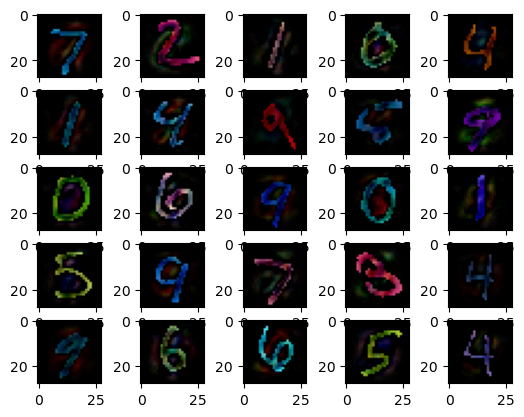

In [117]:
plotTopKK((X_v @ torch.tensor(np.eye(d) - (Vt @ Vt.T),dtype=torch.float)).reshape(ov_dim) )

FileNotFoundError: [Errno 2] No such file or directory: '../results/placehoder.png'

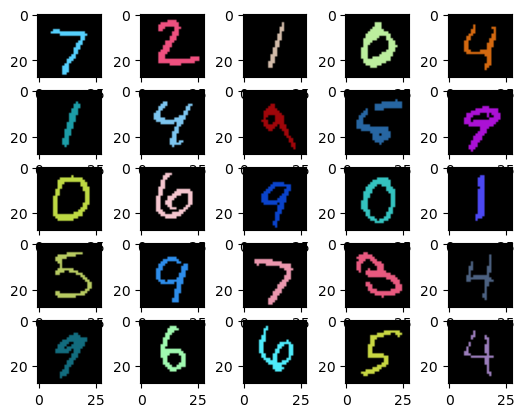

In [118]:
plotTopKK(X_v.reshape(ov_dim))

In [226]:
eigv,eigh = np.linalg.eigh(bias.T @ bias)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [236]:
l = []
for s_c in range(s.shape[-1]):
    for u_b in np.unique(s[:,s_c]):
        U = np.array(X[s[:,s_c]==u_b].mean(axis=0))
        l.append(U)
        #torch.stack((bias_class_variance,U.sum(axis=0).reshape(-1,1)))
        #bias_class_variance = np.hstack((np.array(bias_class_variance),U.reshape(-1,1)))

In [241]:
eigv,eigh = np.linalg.eigh(bias.T @ bias)

In [249]:
Vt = eigh[:,-20:]
X_t @ torch.tensor( np.eye(d) - (Vt @ Vt.T),dtype=torch.float) 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

FileNotFoundError: [Errno 2] No such file or directory: '../results/placehoder.png'

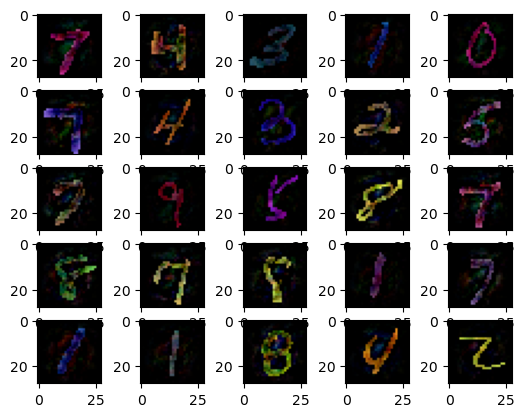

In [252]:
plotTopKK((X_t @ torch.tensor(np.eye(d) - (Vt @ Vt.T),dtype=torch.float)).reshape(ov_dim) )

FileNotFoundError: [Errno 2] No such file or directory: '../results/placehoder.png'

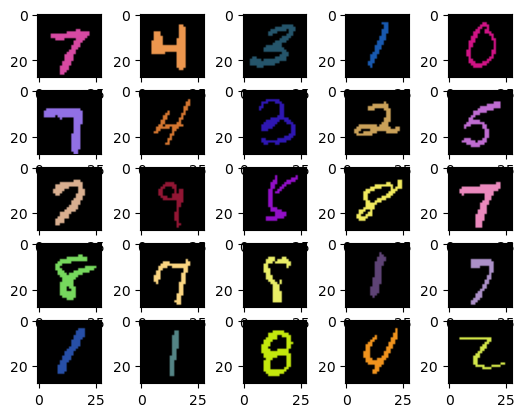

In [254]:
plotTopKK((X_t).reshape(og_dim) )

In [158]:
fig = go.Figure(
    layout=go.Layout(
        xaxis_title="feature 1", yaxis_title="feature 2", width=600,height=400,title='Demonstrating class conditional permutaion'
    )
)
fig.add_trace(go.Scatter(x=[1,1.1,1.3,0.9,1,1.1,1.3,0.9,-1,-0.9,-1.1,-1.3,-1,-0.9,-1.1,-1.3,], y=[1,1.1,1.3,0.9, -1.1,-1.3,-1, -0.9,1,1.1,1.3,0.9, -1.1,-1.3,-1,-0.9], mode='markers'
        ,marker=dict(color=["LightSkyBlue"]*8 + ["DarkSlateGrey"]*8, symbol=["diamond","diamond","diamond","diamond","cross","cross","cross","cross"]*2)))
fig.show()

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import plotly.express as px
import os,wandb

from Dataloader import WholeDataset,ClassConditionalPermutation
from copy import deepcopy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from models.DimRed import PCA,MDA,plotTopKK,zca_whitening_matrix
import torch

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from Metrics import ComputeMetrics

compute_metrics = ComputeMetrics(10)

if torch.cuda.is_available():
    device = "cuda:5"
else:
    device = "cpu"


os.environ["WANDB_API_KEY"]= "13978bc398bdedd79f4db560bfb4b79e2db711b5"
wandb.login()
wandb.init(
    mode="disabled",
    project="Biased MNIST",
    config={
        "epochs": 100,
        "batch_size": 1000,
        "lr": 1e-2,
        "adversery_weight":False,
        "permutation":False
    })
DATA_DIR = "colored_mnist"


class Args(object):
    def __init__(self,data_split):
        self.data_dir = DATA_DIR
        self.data_split = data_split
        self.color_var = 0.020
config = wandb.config

args_train = Args("train")
train_dataset = WholeDataset(args_train)
args_test  = Args("test")
test_dataset = WholeDataset(args_test)

train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=50000,num_workers=4,pin_memory=True,persistent_workers=True)
test_dataloader = DataLoader(test_dataset,shuffle=False,batch_size=1000,num_workers=4,pin_memory=True,persistent_workers=True)


X_t,l_t,y_t,s_t  = next(iter(train_dataloader))
X_v,l_v,y_v,s_v  = next(iter(test_dataloader))

og_dim = X_t.shape
ov_dim = X_v.shape
print(ov_dim)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaudisac (hal-msu). Use `wandb login --relogin` to force relogin
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/research/hal-gaudisac/project802/Dataloader.py:106: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1674893616450/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  label_image = torch.from_numpy(np.transpose(label_image,(2,0,1)))
/research/hal-gaudisac/project802/Datalo

torch.Size([1000, 3, 28, 28])


In [13]:
Xt_flat  = X_t.flatten(start_dim=1)
#W_ZCA = zca_whitening_matrix(Xt_flat)
#Xt_flat = (W_ZCA  @ Xt_flat.T).T
mda  = MDA(num_dim=10)

Z = mda.fit(Xt_flat,y_t)#,s_t
X_p = Xt_flat @ mda.projection_space 
X_hat = (X_p @ mda.reconstruction_space).reshape(og_dim)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_p, y_t)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(True)
tensor(False)
tensor(False)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [10]:
l=[]
for X_v,l_v,y_v,s_v in iter(test_dataloader):
    Xv_flat  = X_v.flatten(start_dim=1)
    #Xv_flat = (W_ZCA  @ Xv_flat.T).T
    U = Xv_flat @ mda.projection_space
    fig = px.scatter(
        U, x=0, y=1,
        color=y_v,labels={'color': 'digit'}
    )
    y_pred = clf.predict(U)
    metrics = compute_metrics(torch.tensor(y_pred),y_v)
    l.append(metrics)

In [12]:
u =[]
for metric in l:
    u.append(metric[1]["accuracy"].item())
u = np.array(u)
u.mean(),np.sqrt(u.var())

(0.40856024622917175, 0.02144453582897629)

In [9]:
l=[]
for X_v,l_v,y_v,s_v in iter(train_dataloader):
    Xv_flat  = X_v.flatten(start_dim=1)
    #Xv_flat = (W_ZCA  @ Xv_flat.T).T
    U = Xv_flat @ mda.projection_space
    print(U.shape)
    y_pred = clf.predict(U)
    metrics = compute_metrics(torch.tensor(y_pred),y_v)
    l.append(metrics)
    break

KeyboardInterrupt: 

In [10]:
u =[]
for metric in l:
    u.append(metric[1]["accuracy"].item())
u = np.array(u)
u.mean(),np.sqrt(u.var())

(0.9067250490188599, 0.0)

In [7]:
from tqdm import tqdm
import random
Xt_flat  = X_t.flatten(start_dim=1)
d =  Xt_flat.shape[-1] #number of diamensions

bias_class_variance = np.empty((d,1))

for c in tqdm(np.unique(y_t)):
    for s_c in range(s_t.shape[-1]):
        for u_b in random.sample(sorted(np.unique(s_t[y_t==c][:,s_c])),3):
            U = Xt_flat[y_t==c][s_t[y_t==c][:,s_c]==u_b].mean(axis=0) -  Xt_flat[y_t==c].mean(axis=0,keepdims=True)
            bias_class_variance = np.hstack((np.array(bias_class_variance),U.reshape(-1,1)))
eigv,eigh = np.linalg.eigh(bias_class_variance @ bias_class_variance.T)

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


In [8]:
Vt = eigh[:,-10:]
Xt_clean = Xt_flat @ torch.tensor(np.eye(d) - (Vt @ Vt.T),dtype=torch.float)
#plotTopKK((Xt_flat @ torch.tensor(np.eye(d) - (Vt @ Vt.T),dtype=torch.float)).reshape(og_dim) )

In [9]:
Xt_clean

tensor([[ 0.0000e+00,  2.4871e-17, -2.5323e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  6.3005e-17, -8.1714e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -3.2127e-17, -1.2174e-15,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00, -3.3405e-17, -1.3824e-15,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.1150e-17, -5.3731e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  8.1240e-17, -4.4081e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [11]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(Xt_clean, y_t)

In [ ]:
l=[]
for X_v,l_v,y_v,s_v in iter(test_dataloader):
    Xv_flat  = X_v.flatten(start_dim=1)
    #Xv_flat = (W_ZCA  @ Xv_flat.T).T
    U = Xv_flat @ torch.tensor(np.eye(d) - (Vt @ Vt.T),dtype=torch.float)
    fig = px.scatter(
        U, x=0, y=1,
        color=y_v,labels={'color': 'digit'}
    )
    y_pred = clf.predict(U)
    metrics = compute_metrics(torch.tensor(y_pred),y_v)
    l.append(metrics)

In [51]:
###MDA experiments

Xt_flat  = X_t.flatten(start_dim=1)
mda = MDA(num_dim=10)

Z = mda.fit(Xt_flat,y_t)
X_p = Xt_flat @ mda.projection_space 
X_hat = (X_p @ mda.reconstruction_space).reshape(og_dim)

l=[]
for X_v,l_v,y_v,s_v in iter(train_dataloader):
    Xv_flat  = X_v.flatten(start_dim=1)
    U = Xv_flat @ mda.projection_space
    fig = px.scatter(
        U, x=0, y=1,
        color=y_v,labels={'color': 'digit'}
    )
    #fig.write_image(f'../results/PCA.png')

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel="rbf"))
    clf.fit(X_p, y_t)
    y_pred = clf.predict(U)
    metrics = compute_metrics(torch.tensor(y_pred),y_v)
    l.append(metrics)

KeyboardInterrupt: 

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
Z = clf.fit_transform(Xt_flat, y_t)
LinearDiscriminantAnalysis()
print(clf.predict(Xt_flat))

[0 8 0 ... 0 6 3]


In [5]:
plt.scatter(Z[:,0],Z[:,1],c=y_t)

NameError: name 'plt' is not defined

In [18]:
fig = px.scatter(
     (Xt_flat @ pca.projection_space), x=1, y=2,
    color=y_t,labels={'color': 'digit'}
)
fig.show()  

In [15]:
((Xv_flat @ mda.projection_space)[:1000,:])

torch.Size([1000, 10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


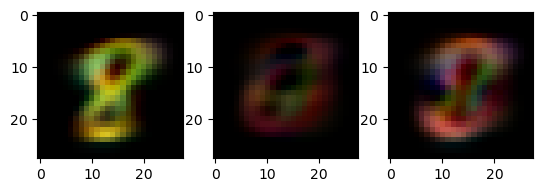

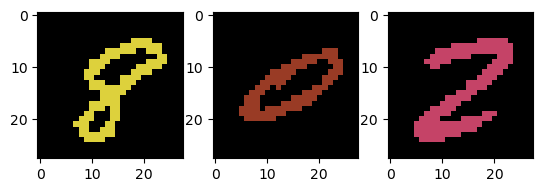

In [14]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3)

ax[0].imshow(np.transpose((Xv_flat @ mda.projection_space @ mda.reconstruction_space ).reshape(-1,*ov_dim[1:])[y_v==8][1],(1,2,0)))
ax[1].imshow(np.transpose((Xv_flat @ mda.projection_space @ mda.reconstruction_space).reshape(-1,*ov_dim[1:])[y_v==0][1],(1,2,0)))
ax[2].imshow(np.transpose((Xv_flat @ mda.projection_space @ mda.reconstruction_space).reshape(-1,*ov_dim[1:])[y_v==2][1],(1,2,0)))

fig.show()
fig,ax = plt.subplots(1,3)
ax[0].imshow(np.transpose((Xv_flat[y_v==8] ).reshape(-1,*ov_dim[1:])[1],(1,2,0)))
ax[1].imshow(np.transpose((Xv_flat[y_v==0] ).reshape(-1,*ov_dim[1:])[1],(1,2,0)))
ax[2].imshow(np.transpose((Xv_flat[y_v==2] ).reshape(-1,*ov_dim[1:])[1],(1,2,0)))
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


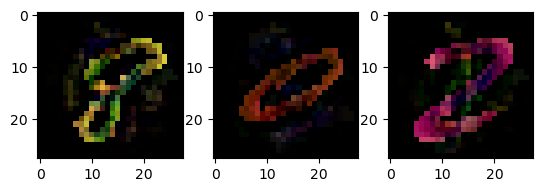

In [23]:
fig,ax = plt.subplots(1,3)

ax[0].imshow(np.transpose((Xv_flat @ P @ P.T ).reshape(-1,*ov_dim[1:])[y_v==8][1],(1,2,0)))
ax[1].imshow(np.transpose((Xv_flat @ P @ P.T).reshape(-1,*ov_dim[1:])[y_v==0][1],(1,2,0)))
ax[2].imshow(np.transpose((Xv_flat @ P @ P.T).reshape(-1,*ov_dim[1:])[y_v==2][1],(1,2,0)))

fig.show()

In [22]:
P = torch.tensor(np.eye(d) - (Vt @ Vt.T),dtype=torch.float)
Xt_flat @ P @ P.T

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [33]:
mda.reconstruction_space[:2].shape

torch.Size([2, 2352])

In [4]:
Xt_flat  = X_t.flatten(start_dim=1)
#W_ZCA = zca_whitening_matrix(Xt_flat)
#Xt_flat = (W_ZCA  @ Xt_flat.T).T
pca  = PCA(num_dim=10)

Z = pca.fit(Xt_flat)#,s_t
X_p = Xt_flat @ pca.projection_space 
X_hat = (X_p @ pca.reconstruction_space).reshape(og_dim)

In [1]:
args_train = Args("train")
train_dataset = WholeDataset(args_train)
args_test  = Args("test")
test_dataset = WholeDataset(args_test)

NameError: name 'Args' is not defined